In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
import compression.IMNN.IMNN_delfi as IMNN
%matplotlib inline

In [3]:
### SET UP THE SIMULATOR ###

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShear(pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb')), 
                                                           lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, 
                                                           nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
#def simulator(theta, seed, simulator_args):
#    return CosmicShearSimulator.simulate(theta, seed)

def simulator(theta, seed, simulator_args):
    simulation = CosmicShearSimulator.simulate(theta, seed)
    nmodes = simulation.shape[0]
    nz = simulation.shape[1]
    d = np.zeros((int(nmodes*nz*(nz+1)/2)))
    for i in range(nmodes):
        x = np.tril(simulation[:, :, i])
        d[i*int(nz*(nz+1)/2):(i+1)*int(nz*(nz+1)/2)] = x[x != 0]
    return d

def derivative_simulator(theta, seed, h, derivative_args):
    simulation = CosmicShearSimulator.compute_derivatives(theta, h)
    params = simulation.shape[0]
    nmodes = simulation.shape[1]
    nz = simulation.shape[2]
    d = np.zeros((params, int(nmodes*nz*(nz+1)/2)))
    for j in range(params):
        for i in range(nmodes):
            x = np.tril(simulation[j, :, :, i])
            d[j, i*int(nz*(nz+1)/2):(i+1)*int(nz*(nz+1)/2)] = x[x != 0]
    return d
    
simulator_args = None
derivative_args = None

In [4]:
### SET UP THE PRIOR ###

# Define the priors parameters
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Prior
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [5]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
h = theta_fiducial*0.05#np.array([0.001, 0.05, 0.05, 0.1, 0.001])

# Number of parameters to train IMNN
initial_sims = 10000
partial_fraction = 1.

# Filename for saving IMNN
filename = 'cosmic_shear'

# Get shape of the simulation
shape = list(simulator(theta_fiducial, np.random.randint(1e8), simulator_args).shape)
# Build training simulations for IMNN (andsave them) and initialise IMNN
compression_network = IMNN.get_network(simulator, simulator_args, shape, theta_fiducial, h, initial_sims, partial_fraction, filename, 1e-3, make_simulations = False, partials_only = False, load_network = True, true_derivatives = False, derivative_simulator = derivative_simulator, derivative_args = derivative_args)

# Train IMNN
# Number of training epochs
num_epochs = 500

IMNN.train_IMNN(compression_network, num_epochs)
#IMNN.plot_train_history(compression_network)

# IMNN score
compressor = IMNN.IMNN_compressor
compressor_args = compression_network

IMNN_summary = IMNN.IMNN_MLE

# Pull out Fisher matrix inverse
Finv = np.linalg.inv(compression_network.sess.run(compression_network.test_F))

number of partial simulations =  10000
[550, 275, 137, 68, 34, 17, 8]
saving model as compression/cosmic_shear.meta
INFO:tensorflow:Restoring parameters from compression/cosmic_shear


100%|██████████| 500/500 [02:30<00:00,  3.99it/s, detF=3.7e+20, detF_test=1.08e+20] 


saving the graph as compression/cosmic_shear.meta


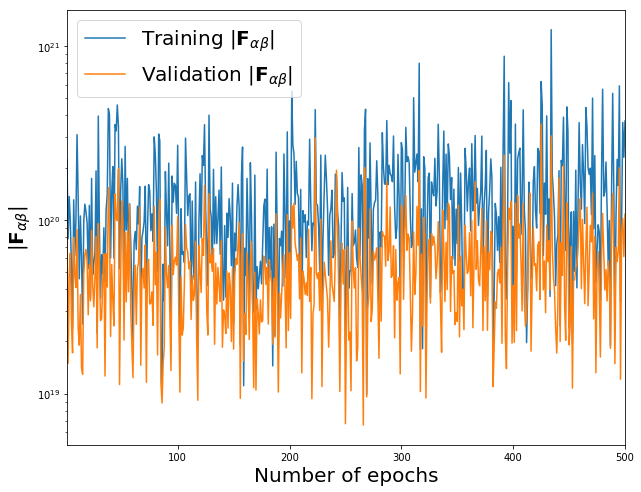

In [8]:
#IMNN.train_IMNN(compression_network, 5000, to_continue = True)
#compression_network.history["det(F)"][-1] = compression_network.history["det(F)"][-1] * 1000
IMNN.plot_train_history(compression_network)
#Finv = np.linalg.inv(compression_network.sess.run(compression_network.test_F))

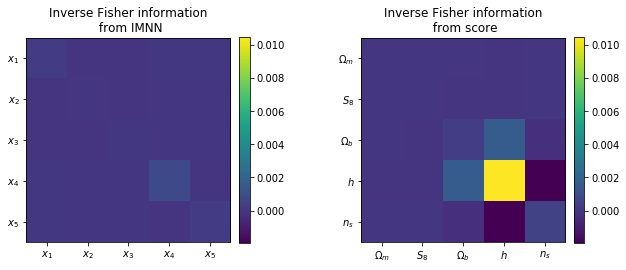

In [7]:
#Finv_score = np.genfromtxt('simulators/cosmic_shear_nuisances/results_marginalized/Finv.dat')
Finv_score = np.load('Finv.npy')
min_val = min(np.min(Finv_score), np.min(Finv))
max_val = max(np.max(Finv_score), np.max(Finv))
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(wspace = 0.5)
p = ax[0].imshow(Finv, vmin = min_val, vmax = max_val)
plt.colorbar(p, ax = ax[0], fraction = 0.046, pad = 0.04)
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_xticklabels([r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$"])
ax[0].set_yticks([0, 1, 2, 3, 4])
ax[0].set_yticklabels([r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$"])
ax[0].set_title("Inverse Fisher information\n from IMNN")
q = ax[1].imshow(Finv_score, vmin = min_val, vmax = max_val)
plt.colorbar(q, ax = ax[1], fraction = 0.046, pad = 0.04)
ax[1].set_xticks([0, 1, 2, 3, 4])
ax[1].set_xticklabels([r"$\Omega_m$", r"$S_8$", r"$\Omega_b$", r"$h$", r"$n_s$"])
ax[1].set_yticks([0, 1, 2, 3, 4])
ax[1].set_yticklabels([r"$\Omega_m$", r"$S_8$", r"$\Omega_b$", r"$h$", r"$n_s$"])
ax[1].set_title("Inverse Fisher information\n from score");
plt.savefig("inverse_fisher_information_comparison.pdf", bbox_inches = "tight")

In [9]:
### LOAD IN THE DATA VECTOR ###
simulation = simulator(theta_fiducial, 42, simulator_args)
data = compressor(simulation, compressor_args)
summary_data = IMNN_summary(simulation, compressor_args)
print("Fiducial parameter values = ", theta_fiducial)
print("IMNN summaries = ", data)
print("IMNN maximum likelihood estimate = ", summary_data)
print("|F|", np.linalg.det(compression_network.sess.run(compression_network.test_F)))
print("|F_score|", np.linalg.det(np.linalg.inv(Finv_score)))
print("IMNN Fisher forecast =  ", np.sqrt(np.diag(Finv)))
print("Score Fisher forecast = ", np.sqrt(np.diag(Finv_score)))

Fiducial parameter values =  [0.3  0.8  0.05 0.7  0.96]
IMNN summaries =  [ 4.4907948e+11 -4.4534112e+10  4.0946840e+11 -4.0179036e+10
 -4.2572710e+10]
IMNN maximum likelihood estimate =  [0.29924408 0.79982394 0.04972643 0.7015947  0.96126395]
|F| 1.0769741e+20
|F_score| 4.277631752126061e+22
IMNN Fisher forecast =   [0.0145498  0.00314723 0.00711035 0.02835825 0.01620165]
Score Fisher forecast =  [0.00367217 0.00114384 0.01698272 0.10234931 0.02293382]


n = compression_network

from string import ascii_lowercase
Δθ = tf.stack(tf.meshgrid(*[(n.prior - tf.expand_dims(n.θ_fid, 1))[i] for i in range(n.n_params)]), axis = 0)
a = tf.einsum("ij,ij->i", n.output, tf.einsum("ij,kj->ki", n.test_iC, n.output))
b = tf.einsum("i,ji->j", n.test_μ, tf.einsum("ij,kj->ki", n.test_iC, n.output))
c = tf.einsum("ij,j->i", n.output, tf.einsum("ij,j->i", n.test_iC, n.test_μ))
d = tf.einsum("i,i->", n.test_μ, tf.einsum("ij,j->i", n.test_iC, n.test_μ))
e = a + b + c + d
f = tf.einsum("ij,kj->ki", n.test_dμdθ, tf.einsum("ij,kj->ki", n.test_iC, n.output))
g = tf.einsum("ij,kj->ik", n.output, tf.einsum("ij,kj->ki", n.test_iC, n.test_dμdθ))
h = tf.expand_dims(tf.einsum("ij,j->i", n.test_dμdθ, tf.einsum("ij,j->i", n.test_iC, n.test_μ)), 0)
i = tf.expand_dims(tf.einsum("i,ji->j", n.test_μ, tf.einsum("ij,kj->ki", n.test_iC, n.test_dμdθ)), 0)
j = tf.tensordot(- f - g + h + i, Δθ, [[1], [0]])
#j = tf.einsum("ij,kj->ik", n.test_dμdθ, tf.einsum("ij,kj->ki", n.test_iC, n.test_dμdθ))
for i in range(n.n_params):
    e = tf.expand_dims(e, 1)
AL = - 0.5 * (e + j)

#h = tf.tensordot(Δθ, g, axes = [[0], [1]])
#for c in ascii_lowercase[8:]:
#    print(c)
#asymptotic_likelihood = tf.exp(- 0.5 * (tf.expand_dims(tf.expand_dims(tf.einsum("ij,ij->i", n.output, tf.einsum("ij,kj->ki", n.test_iC, n.output)) + tf.einsum("i,ji->j", n.test_μ, tf.einsum("ij,kj->ki", n.test_iC, n.output)) + tf.einsum("ij,j->i", n.output, tf.einsum("ij,j->i", n.test_iC, n.test_μ)) + tf.einsum("i,i->", n.test_μ, tf.einsum("ij,j->i", n.test_iC, n.test_μ)), 1), 2) - tf.einsum("ijk,ij->ijk", Δθ, tf.einsum("ij,kj->ki", n.test_dμdθ, tf.einsum("ij,kj->ki", n.test_iC, n.output))) - tf.einsum("ijk,ij->ijk", Δθ, tf.einsum("ij,kj->ik", n.output, tf.einsum("ij,kj->ki", n.test_iC, n.test_dμdθ))) + tf.einsum("ijk,j->ijk", Δθ, tf.einsum("ij,j->i", n.test_dμdθ, tf.einsum("ij,j->i", n.test_iC, n.test_μ))) + tf.einsum("ijk,j->ijk", Δθ, tf.einsum("i,ji->j", n.test_μ, tf.einsum("ij,kj->ki", n.test_iC, n.test_dμdθ))) + tf.einsum("ijk,ijk->ijk", Δθ, tf.einsum("ijk,j->ijk", Δθ, tf.einsum("ij,ij->i", n.test_dμdθ, tf.einsum("ij,kj->ki", n.test_iC, n.test_dμdθ))))))
#        return asymptotic_likelihood / tf.reduce_sum(tf.einsum("ijk,ij->ijk", asymptotic_likelihood, (n.prior[:, :, 1] - n.prior[:, :, 0])), 2, keepdims = True)

plot_range = np.array([np.linspace(lower[i], upper[i], 25) for i in range(5)])
A = np.exp(n.sess.run(AL, feed_dict = {n.x: [simulation], n.prior: plot_range, n.dropout: 1.}))
#AL = compression_network.asymptotic_likelihood([simulation], [plot_range])[0]

fig, ax = plt.subplots(n.n_params, n.n_params, figsize = (20, 20))
params = np.array([i for i in range(n.n_params)])
for i in range(n.n_params):
    for j in range(n.n_params):
        if j > i:
            ax[i, j].set_axis_off()
        elif i == j:
            ax[i, j].plot(plot_range[i], np.sum(A[0], tuple(params[params != i])))
        else:
            sum_axes = params[params != i]
            sum_axes = tuple(sum_axes[sum_axes != j])
            ax[i, j].contourf(plot_range[j], plot_range[i], np.sum(A[0], sum_axes).T)

In [10]:
## Create the MDN
NDE = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

## Create the MAF
#NDE = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh)

In [11]:
# Create the DELFI object
asymptotic_proposal = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)
nwalkers=100
proposal_chain_length=10
posterior_chain_length=10
proposal_samples = np.array([asymptotic_proposal.draw() for i in range(nwalkers*proposal_chain_length)])
posterior_samples = np.array([compressor(simulator(asymptotic_proposal.draw(), np.random.randint(1e8), simulator_args), compressor_args) for i in range(nwalkers * posterior_chain_length)])
DelfiNDE = delfi.Delfi(data, prior, NDE, Finv, theta_fiducial, proposal_samples, posterior_samples, nwalkers = nwalkers, proposal_chain_length = proposal_chain_length, posterior_chain_length = posterior_chain_length,
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results/")

# Do the Fisher pre-training
DelfiNDE.fisher_pretraining(200000, prior, epochs=200, patience=10)

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 2000
n_batch = 500
n_populations = 15

# Do the SNL training
DelfiNDE.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, compressor_args = compressor_args)

In [ ]:
plt.close()
columnwidth = 18 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 15,
                 'legend.fontsize': 15,
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})

# Trace plot of the training and validation loss as a function of the number of simulations ran
plt.scatter(DelfiNDE.sequential_nsims, DelfiNDE.sequential_training_loss, s = 20, alpha = 0.5)
plt.plot(DelfiNDE.sequential_nsims, DelfiNDE.sequential_training_loss, color = 'red', lw = 2, alpha = 0.5, label = 'training loss')
plt.scatter(DelfiNDE.sequential_nsims, DelfiNDE.sequential_validation_loss, s = 20, alpha = 0.5)
plt.plot(DelfiNDE.sequential_nsims, DelfiNDE.sequential_validation_loss, color = 'blue', lw = 2, alpha = 0.5, label = 'validation loss')


#plt.fill_between(DelfiMAF.sequential_nsims, (DelfiMAF.sequential_validation_loss[-1]-0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), 
#                 (DelfiMAF.sequential_validation_loss[-1]+0.05)*np.ones(len(DelfiMAF.sequential_validation_loss)), color = 'grey', alpha = 0.2 )

plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log loss, $-\mathrm{ln}\,U$')
#plt.savefig('../../paper_II/plots/convergence_fixedII.pdf')
plt.tight_layout()
plt.legend()
plt.show()

Removed no burn in
Removed no burn in


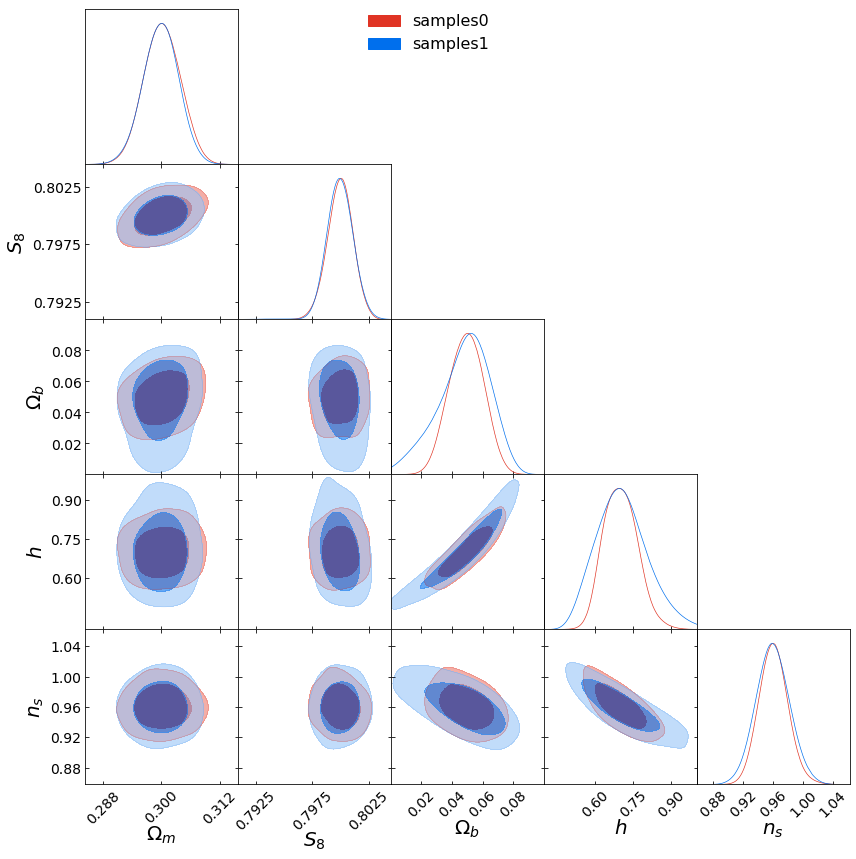

In [14]:
emcee_samples = np.loadtxt("emcee_samples.dat")
posterior_samples = np.loadtxt("posterior_samples.dat")
#DelfiNDE.triangle_plot([emcee_samples, posterior_samples, DelfiNDE.posterior_samples])
DelfiNDE.triangle_plot([emcee_samples, posterior_samples])

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_compressed_summaries.npy", DelfiNDE.xs)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_parameters.npy", DelfiNDE.ps)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_theta_fiducial.npy", DelfiNDE.theta_fiducial)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_Finv.npy", Finv)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_fisher_errors.npy", DelfiNDE.fisher_errors)

In [ ]:
np.save("simulators/cosmic_shear/pre_ran_sims/IMNN_real_data.npy", data)

In [ ]:
distance = np.einsum("ij,ij->i", (DelfiNDE.ps - DelfiNDE.xs), np.einsum('ij,kj->ki', Finv, (DelfiNDE.ps - DelfiNDE.xs)))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.5)
ax[0].scatter(DelfiNDE.ps[:, 0], DelfiNDE.xs[:, 0], s = 2, c = distance)
ax[0].set_xlabel("Scaled $\Omega_{\sf m}$\nparameter draw")
ax[0].set_ylabel("Scaled $\Omega_{\sf m}$ IMNN score")
ax[1].scatter(DelfiNDE.ps[:, 1], DelfiNDE.xs[:, 1], s = 2, c = distance)
ax[1].set_xlabel("Scaled $S_8$\nparameter draw")
ax[1].set_ylabel("Scaled $S_8$ IMNN score")
ax[2].scatter(DelfiNDE.ps[:, 2], DelfiNDE.xs[:, 2], s = 2, c = distance)
ax[2].set_xlabel("Scaled $\Omega_{\sf b}$\nparameter draw")
ax[2].set_ylabel("Scaled $\Omega_{\sf b}$ IMNN score")
ax[3].scatter(DelfiNDE.ps[:, 3], DelfiNDE.xs[:, 3], s = 2, c = distance)
ax[3].set_xlabel("Scaled $h$\nparameter draw")
ax[3].set_ylabel("Scaled $h$ IMNN score")
p = ax[4].scatter(DelfiNDE.ps[:, 4], DelfiNDE.xs[:, 4], s = 2, c = distance)
ax[4].set_xlabel("Scaled $n_{\sf s}$\nparameter draw")
ax[4].set_ylabel("Scaled $n_{\sf s}$ IMNN score");
plt.colorbar(p, ax = ax[4])
plt.savefig("score_parameter_comparison.pdf", bbox_inches = 'tight')

In [ ]:
params = DelfiNDE.ps * DelfiNDE.fisher_errors + DelfiNDE.theta_fiducial
scores = DelfiNDE.xs * DelfiNDE.fisher_errors + DelfiNDE.theta_fiducial
p_s_distance = np.einsum("ij,ij->i", (params - scores), np.einsum('ij,kj->ki', Finv, (params - scores))) 

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.5)
ax[0].scatter(params[:, 0], scores[:, 0], s = 2, c = p_s_distance, alpha = 0.5)
ax[0].set_xlabel("$\Omega_{\sf m}$\nparameter draw")
ax[0].set_ylabel("$\Omega_{\sf m}$ IMNN score")
ax[1].scatter(params[:, 1], scores[:, 1], s = 2, c = p_s_distance, alpha = 0.5)
ax[1].set_xlabel("$S_8$\nparameter draw")
ax[1].set_ylabel("$S_8$ IMNN score")
ax[2].scatter(params[:, 2], scores[:, 2], s = 2, c = p_s_distance, alpha = 0.5)
ax[2].set_xlabel("$\Omega_{\sf b}$\nparameter draw")
ax[2].set_ylabel("$\Omega_{\sf b}$ IMNN score")
ax[3].scatter(params[:, 3], scores[:, 3], s = 2, c = p_s_distance, alpha = 0.5)
ax[3].set_xlabel("$h$\nparameter draw")
ax[3].set_ylabel("$h$ IMNN score")
p = ax[4].scatter(params[:, 4], scores[:, 4], s = 2, c = p_s_distance, alpha = 0.5)
ax[4].set_xlabel("$n_{\sf s}$\nparameter draw")
ax[4].set_ylabel("$n_{\sf s}$ IMNN score");
plt.colorbar(p, ax = ax[4])
plt.savefig("score_parameter_comparison.pdf", bbox_inches = 'tight')